In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import numpy as np
import json
import matplotlib.ticker as ticker

deltasHeatMapDF = pd.read_csv('data/deltasHeatMapDF.csv',index_col=0)
budget = pd.read_csv('data/budget.csv',index_col=0)
projectCosts = pd.read_csv('data/projectCosts.csv',index_col=0)
costStatusHeatMapDF = pd.read_csv('data/costStatusHeatMapDF.csv',index_col=0)
projectSteps = pd.read_csv('data/projectSteps.csv',index_col=0)

# Q1 - Are Projects *Actually* Delayed?

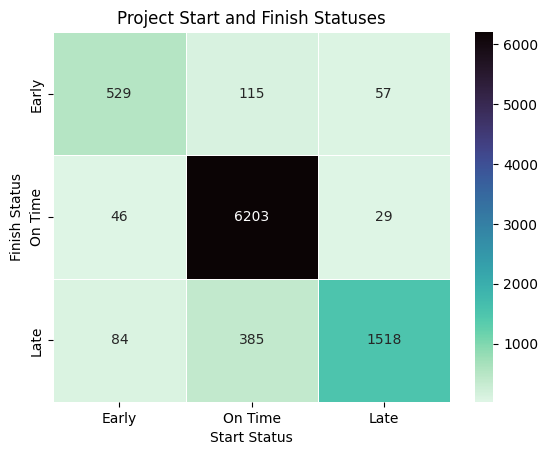

In [72]:


sns.heatmap(deltasHeatMapDF,
            annot=True,
            fmt="d",
            linewidths=.5,
            cmap="mako_r");
plt.xlabel('Start Status');
plt.ylabel('Finish Status');
plt.title('Project Start and Finish Statuses');
# plt.annotate('(Count of Projects)', xy=(0.5, 1.0), xycoords='axes fraction', ha='center', va='center', fontsize=10, color='gray');


# plt.savefig('plots/Project_Start_Finish_heatmap.png', dpi=300, bbox_inches='tight')

## Where are projects delayed?

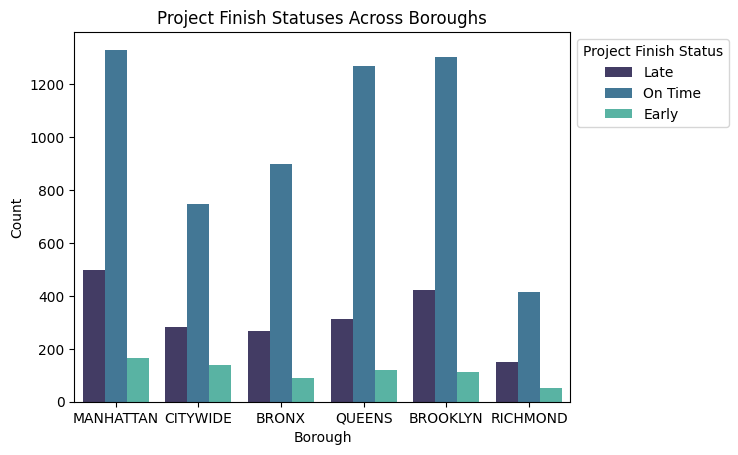

In [108]:
# make a bar plot that shows the project finish status by boro
sns.countplot(x="boro", 
              hue="endStatus", 
              data=projectCosts,
              palette="mako");
plt.xlabel('Borough');
plt.ylabel('Count');
plt.title('Project Finish Statuses Across Boroughs');
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Project Finish Status')

plt.savefig('plots/Project_Finish_Statuses_by_Boro.png', dpi=300, bbox_inches='tight')

## Another Plot?
-> get percentages  
-> make a table ?  
-> sns.pairplot?  
-> correlation heatmap (data = dataset.corr())

### Reasons why projects are delayed

In [43]:

budget['delay_desc'].value_counts()  # 12 different delay descriptions

PROJECT DELAYED DUE TO BUDGETARY CONSTRAINTS              17574
PROJECT DELAYED DUE TO CHANGES IN SCOPE/DESIGN            17432
PROJECT DELAYED DUE TO UNFORESEEN SITE/FIELD CONDITION     7242
PROJECT DELAYED PENDING RESOLUTION OF LEGAL ISSUES          723
PROJECT DELAYED PENDING APPROVAL OF NECESSARY PERMITS       266
PROJECT DELAYED PENDING NON-CITY GRANT APPROVAL             165
PROJECT DELAYED DUE TO UNFORESEEN HAZARDOUS CONDITION        94
PROJECT DELAYED DUE TO SCHEDULING OF UTILITY WORK            83
PROJECT DELAYED DUE TO UNAVAILABILITY OF PRODUCT             61
PROJECT DELAYED PENDING RELEASE OF NEW TECHNOLOGY            34
PROJECT DELAYED PENDING APPROVAL OF STATE REQ CONTRACT       23
PROJECT DELAYED RESULTING FROM CONTRACTOR DEFAULT            22
Name: delay_desc, dtype: int64

# Q2 - Budget Things

### Budget Status by Borough

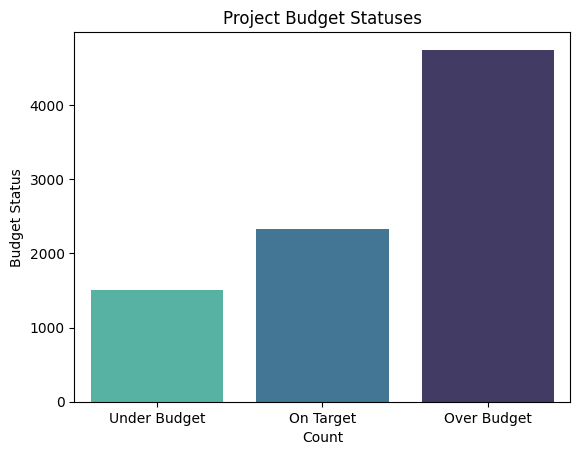

In [125]:


# make a bar plot of the number of projects that were over budget, on budget, and under budget
sns.countplot(x="costStatus",
              data=projectCosts,
              order=["Under Budget","On Target","Over Budget"],
              palette="mako_r");
plt.xlabel('Count');
plt.ylabel('Budget Status');
plt.title('Project Budget Statuses');

plt.savefig('plots/Project_Budget_Status_bar.png', dpi=300, bbox_inches='tight')


In [109]:
# projectCosts['project_id'].nunique()  # 1,000 unique projects

8578

In [126]:
""" Managing Agency Table""" #https://stackoverflow.com/questions/35523635/extract-values-in-pandas-value-counts

json.loads(projectCosts['managing_agcy'].value_counts().to_json())

# projectCosts['managing_agcy'].str.title()
agencyDF = projectCosts['managing_agcy'].value_counts().to_frame() \
        .reset_index().rename(columns={"index":"Managing Agency","managing_agcy":"Count"})
# pd.crosstab(projectCosts['managing_agcy'], projectCosts['costStatus'])

agencyDF.to_json(path_or_buf='data/agencyDF_records.json',orient='records')
agencyDF.to_json(path_or_buf='data/agencyDF_columns.json',orient='columns')

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_json.html
# https://github.com/alshedivat/al-folio/blob/master/_posts/2023-03-21-tables.md

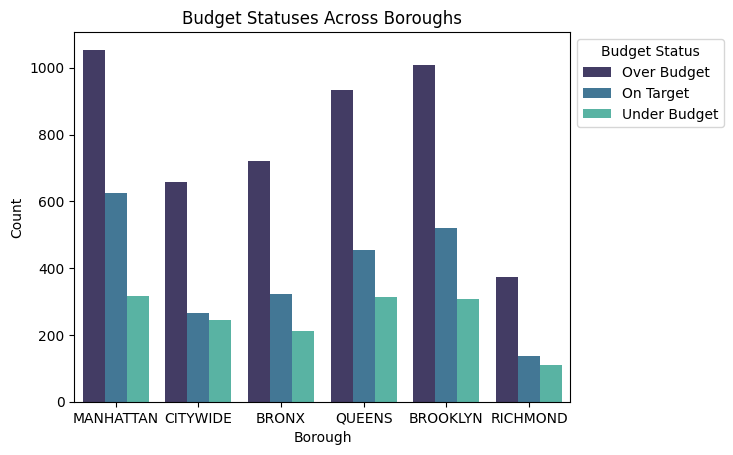

In [122]:
# make a bar plot that shows the number of projects that were over/under budget by boro
sns.countplot(x="boro", 
              hue="costStatus", 
              data=projectCosts,
              palette="mako");
plt.xlabel('Borough');
plt.ylabel('Count');
plt.title('Budget Statuses Across Boroughs');
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Budget Status')

plt.savefig('plots/Project_Budget_Status_boro_bar.png', dpi=300, bbox_inches='tight')

# """Make it customizable by boro"""
# import plotly.express as px
# borough = 'BROOKLYN'

# filteredBoro = projectCosts[projectCosts['boro'] == borough]
# # sns.countplot(x="costStatus", data=filteredBoro, order=["Under Budget","On Target","Over Budget"])

# fig = px.bar(filteredBoro,
#              x='boro',
#              color='costStatus',
#              barmode='group',
#              category_orders={'costStatus': ["Under Budget","On Target","Over Budget"]},
#              title='Count of Cost Status Across Boroughs'
#             )

# fig.update_layout(
#     xaxis=dict(title='Borough'),
#     yaxis=dict(title='Count'),
#     legend_title='Cost Status'
# )

# fig.show()

### Budget Status by Project Finish Status

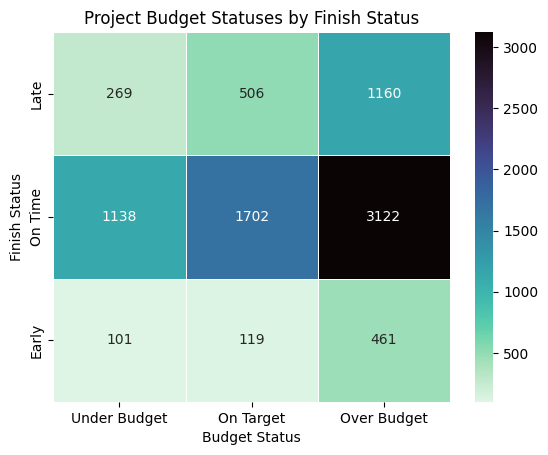

In [129]:


sns.heatmap(costStatusHeatMapDF,
            annot=True,
            fmt="d",
            linewidths=.5,
            cmap="mako_r");
plt.xlabel("Budget Status")
plt.ylabel("Finish Status")
plt.title("Project Budget Statuses by Finish Status");
plt.savefig('plots/Budget_Status_Late_Projects_heatmap.png', dpi=300, bbox_inches='tight')

### Budget Deltas by Agencies

In [118]:
# what is the average cost delta for projects by managing agnecy?
agencyBudgets = projectCosts.groupby('managing_agcy')[['managing_agcy','cost_delta']] \
    .agg({ 'cost_delta': 'mean'}) \
    .astype({'cost_delta': 'int64'}) \
    .sort_values('cost_delta', ascending=False).reset_index()

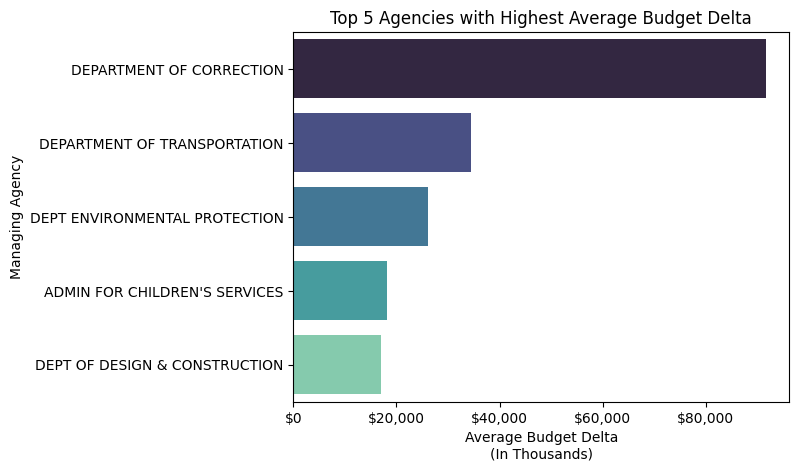

In [119]:


# plot the top 5 agencies with the highest average cost delta
sns.barplot(y="managing_agcy",
            x="cost_delta",
            data=agencyBudgets.head(),
            order=agencyBudgets['managing_agcy'].head(),
            palette="mako");
plt.xlabel('Average Budget Delta\n(In Thousands)');
plt.ylabel('Managing Agency');
plt.title('Top 5 Agencies with Highest Average Budget Delta');
# Format x-axis tick labels with a dollar sign
formatter = ticker.FuncFormatter(lambda x, _: '${:,.0f}'.format(x))   # Format labels as $value
plt.gca().xaxis.set_major_formatter(formatter)
plt.savefig('plots/Top_5_Agencies_Highest_Average_Budget_Delta.png', dpi=300, bbox_inches='tight')


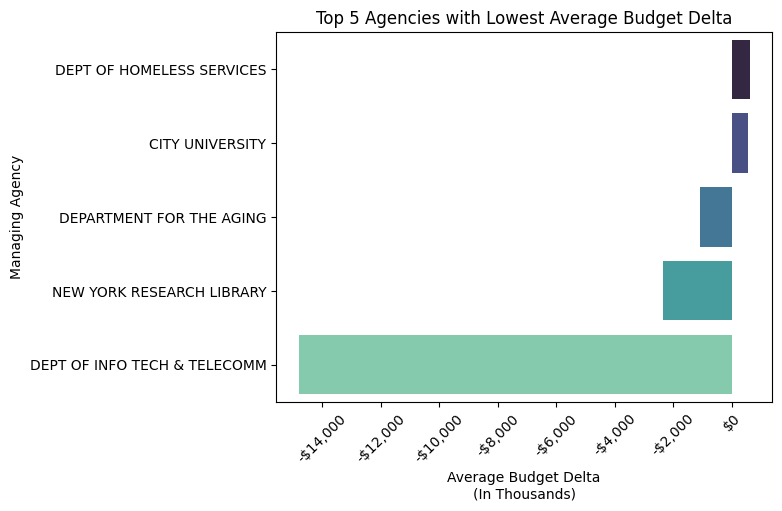

In [120]:
sns.barplot(y="managing_agcy",
            x="cost_delta",
            data=agencyBudgets.tail(),
            order=agencyBudgets['managing_agcy'].tail(),
            palette="mako");
plt.xlabel('Average Budget Delta\n(In Thousands)');
plt.ylabel('Managing Agency');
plt.title('Top 5 Agencies with Lowest Average Budget Delta');


# Format x-axis tick labels with appropriate commas and dollar sign, placing negative sign before the dollar sign
def currency_formatter(x, pos):
    if x < 0:
        return f'-${abs(x):,.0f}'  # If negative, place the negative sign before the dollar sign
    else:
        return f'${x:,.0f}'
formatter = ticker.FuncFormatter(currency_formatter)
plt.gca().xaxis.set_major_formatter(formatter);

# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45);
plt.savefig('plots/Top_5_Agencies_Lowest_Budget_Delta_bar.png', dpi=300, bbox_inches='tight')

### Who paid more for late projects?

In [ ]:
projectCosts['funded_by'] = np.select([
                                    (projectCosts['noncity_pct'] == 1.0) ,
                                    ( (projectCosts['city_pct']<1.0) & (projectCosts['noncity_pct']>0))  # Condition for "Non-City"
                                ],
                                [
                                    'Non City',
                                    'Both'
                                ],
                                default='City'  # Default value if none of the conditions are met
                            ) 

projectCosts.head()


In [34]:
# There are some projects with an initial budget of $0 Let's filter those out
cleanProjectCosts = projectCosts[projectCosts['orig_bud_amt'] != 0]

# what is the average cost delta for projects by 'funded by'?
cleanProjectCosts.groupby('funded_by')[['funded_by','cost_delta']] \
    .agg({ 'cost_delta': 'mean'}) \
    .astype({'cost_delta': 'int64'}) \
    .sort_values('cost_delta', ascending=False).reset_index()

,funded_by,cost_delta
0,Both,733941
1,Non City,184508
2,City,7553
